# Loading and Cleaning

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.data import Dataset
import os
import cv2
from imblearn.over_sampling import SMOTE
from google.cloud import storage
from google.oauth2 import service_account
import numpy as np

2023-03-14 09:24:26.628298: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-14 09:24:27.421598: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-14 09:24:27.421644: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-14 09:24:30.915707: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

## Constants

In [2]:
SOURCE = "local"
BATCH_SIZE = 32
RAW_DATA_PATH = "/home/emilyma/code/FlorenceBoutin/GI_disease_detection/raw_data/normal_vs_polyps"

GCLOUD_PROJECT_ID = "gi-disease-detection"
GCP_REGION = "europe-west4"

BUCKET_NAME = "gi-disease-raw-data"
GOOGLE_APPLICATION_CREDENTIALS = "/home/emilyma/code/emilyhma/gcp/gi-disease-detection-fa509a6759e5.json"

IMAGE_RESCALE_RATIO = 1. / 255
IMAGE_TARGET_WIDTH = 224
IMAGE_TARGET_HEIGHT = 224

## Functions

In [3]:
def load_images(path, class_mode = "categorical"):
    """
    Enter a path to load images from.
    class_mode should be "categorical" if we are calling this function on data with existing categories.
    class_mode should be None if we are calling this function on new data.
    """
    datagen = ImageDataGenerator(rescale = float(IMAGE_RESCALE_RATIO))
    images = datagen.flow_from_directory(path,
                                         target_size = (int(IMAGE_TARGET_WIDTH), int(IMAGE_TARGET_HEIGHT)),
                                         color_mode = "rgb",
                                         batch_size = int(BATCH_SIZE),
                                         class_mode = class_mode)

    return images

In [4]:
def load_images_sample(path, class_mode = "categorical"):
    """
    Enter a path to load images from.
    class_mode should be "categorical" if we are calling this function on data with existing categories.
    class_mode should be None if we are calling this function on new data.
    """
    datagen = ImageDataGenerator(rescale = float(IMAGE_RESCALE_RATIO))
    images = datagen.flow_from_directory(path,
                                         target_size = (int(IMAGE_TARGET_WIDTH), int(IMAGE_TARGET_HEIGHT)),
                                         color_mode = "rgb",
                                         batch_size = 40,
                                         class_mode = class_mode)

    return images

In [5]:
def convert_DI_to_numpy(dataset):
    """
    Converts DirectoryIterator dataset to numpy.array.
    Returns X and y values for each dataset.
    """
    dataset.reset()
    X = np.concatenate([dataset.next()[0] for i in range(dataset.__len__())])
    y = np.concatenate([dataset.next()[1] for i in range(dataset.__len__())])

    return X, y

In [6]:
def train_val_test_generator(source = SOURCE, class_mode = "categorical", number_of_classes = 2):
    """
    If run on existing data, generates the train, validation, and test datasets,
    and the corresponding X and y for train, validation, and test. Set class_mode to "categorical".

    If run on new data, generates the numpy array for the uploaded image. Set class_mode to None.

    If number_of_classes = 2, apply SMOTE to avoid imbalanced classes (normal vs UC + polyps).

    If number_of_classes = 3, do not apply SMOTE since classes are already balanced (normal vs UC vs polyps).
    """
    if source == "local":
        train_directory = os.path.join(RAW_DATA_PATH, "train")
        val_directory = os.path.join(RAW_DATA_PATH, "val")
        test_directory = os.path.join(RAW_DATA_PATH, "test")

    #this doesn't work right now
    if source == "cloud":
        credentials = service_account.Credentials.from_service_account_file(GOOGLE_APPLICATION_CREDENTIALS)
        client = storage.Client(project = GCLOUD_PROJECT_ID, credentials = credentials)
        bucket = client.get_bucket(BUCKET_NAME)

        train_directory = f"gs://{BUCKET_NAME}/train"
        val_directory = f"gs://{BUCKET_NAME}/val"
        test_directory = f"gs://{BUCKET_NAME}/test"

    if class_mode == "categorical":
        X_train, y_train = convert_DI_to_numpy(load_images(train_directory, class_mode = class_mode))
        X_val, y_val = convert_DI_to_numpy(load_images(val_directory, class_mode = class_mode))
        X_test, y_test = convert_DI_to_numpy(load_images(test_directory, class_mode = class_mode))

        #if imbalanced datasets
#         if number_of_classes == 2:
#             oversample = SMOTE()
#             X_train, y_train = oversample.fit_resample(X_train, y_train)
#             X_val, y_val = oversample.fit_resample(X_val, y_val)
#             X_test, y_test = oversample.fit_resample(X_test, y_test)

        return X_train, y_train, X_val, y_val, X_test, y_test

    #need to figure out how to submit the image
    #update "new_image_directory" accordingly
    if class_mode == None:
        numpy_image = convert_numpy_to_TFDataset(load_images("new_image_directory", class_mode = class_mode))

        return numpy_image

In [7]:
def preprocess_images(X: np.array):
    """
    Clean the images in X_train, X_val, and X_test.
    """
    def clean_image(image: np.array):
        """
        Input an image to add a rectangle to cover the green or black box on the resized and normalized image (-1 box).
        """
        # Identified ROI for specific corner box in resized and normalized image
        y1 = 148
        y2 = 224
        x1 = 0
        x2 = 77

        image_clean = cv2.rectangle(image, (x1, y1), (x2, y2), (-1, -1, -1), -1)

        return image_clean

    cleaned_X = []

    for i in range(X.shape[0]):
        temp = (clean_image(X[i, :, :, :]))
        cleaned_X.append(cv2.resize(temp, (100, 100)))

    return cleaned_X

In [8]:
def convert_numpy_to_TFDataset(X, y):
    """
    Converts numpy.array back to TF format but this time a TF dataset.
    """
    dataset = Dataset.from_tensor_slices((X, y)).batch(int(BATCH_SIZE))

    return dataset

In [9]:
def pipeline(class_mode = "categorical"):
    """
    A pipeline of the entire cleaning process.
    If existing data, class_mode = "categorical".
    If new data, class_mode = None.
    """
    X_train, y_train, X_val, y_val, X_test, y_test = train_val_test_generator(class_mode = class_mode, number_of_classes = 2)

    preprocessed_train = preprocess_images(X_train)
    preprocessed_val = preprocess_images(X_val)
    preprocessed_test = preprocess_images(X_test)

    train_dataset = convert_numpy_to_TFDataset(preprocessed_train, y_train)
    val_dataset = convert_numpy_to_TFDataset(preprocessed_val, y_val)
    test_dataset = convert_numpy_to_TFDataset(preprocessed_test, y_test)

    return train_dataset, val_dataset, test_dataset

## Loading `train_dataset`, `val_dataset`, and `test_dataset`

In [10]:
train_dataset, val_dataset, test_dataset = pipeline(class_mode = "categorical")

Found 1600 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


2023-03-14 09:25:18.272190: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/emilyma/.pyenv/versions/3.10.6/envs/GI_disease_detection/lib/python3.10/site-packages/cv2/../../lib64:
2023-03-14 09:25:18.283949: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-14 09:25:18.289854: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-FEC965N): /proc/driver/nvidia/version does not exist
2023-03-14 09:25:18.382691: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

In [11]:
train_dataset

<BatchDataset element_spec=(TensorSpec(shape=(None, 100, 100, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))>

In [12]:
val_dataset

<BatchDataset element_spec=(TensorSpec(shape=(None, 100, 100, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))>

In [13]:
test_dataset

<BatchDataset element_spec=(TensorSpec(shape=(None, 100, 100, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))>

# Basic CNN Model

In [14]:
from tensorflow.keras import models
from tensorflow.keras import Sequential, layers
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import metrics

In [15]:
es = EarlyStopping(restore_best_weights = True)

In [ ]:
model = Sequential()

model.add(layers.Masking(mask_value = -1, input_shape = (100, 100, 3)))

model.add(layers.Conv2D(128, kernel_size = (3, 3), activation = "relu"))
model.add(layers.Conv2D(128, kernel_size = (3, 3), activation = "relu"))
model.add(layers.MaxPool2D(pool_size = (3, 3)))

model.add(layers.Conv2D(64, kernel_size = (2, 2), activation = "relu"))
model.add(layers.Conv2D(64, kernel_size = (2, 2), activation = "relu"))
model.add(layers.MaxPool2D(pool_size = (2, 2)))

model.add(layers.Conv2D(32, kernel_size = (2, 2), activation = "relu"))
model.add(layers.Conv2D(32, kernel_size = (2, 2), activation = "relu"))
model.add(layers.MaxPool2D(pool_size = (2, 2)))

# model.add(layers.Conv2D(16, kernel_size = (2, 2), activation = "relu"))
# model.add(layers.Conv2D(16, kernel_size = (2, 2), activation = "relu"))
# model.add(layers.MaxPool2D(pool_size = (2, 2)))
model.add(layers.Dropout(rate = 0.2))

model.add(layers.Flatten())

# model.add(layers.Dense(500, activation = "relu"))
# model.add(layers.Dense(250, activation = "relu"))
# model.add(layers.Dense(125, activation = "relu"))
model.add(layers.Dense(1000, activation = "relu"))
model.add(layers.Dense(500, activation = "relu"))
model.add(layers.Dense(2, activation = "softmax"))

In [ ]:
model.summary()

In [ ]:
model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["accuracy", metrics.Recall()])

In [ ]:
model.fit(train_dataset_sample, validation_data = val_dataset_sample, epochs = 10, callbacks = [es])

In [ ]:
model.evaluate(test_dataset_sample)

## CNN Confusion Matrix

In [16]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

### Predicted Values

In [ ]:
predictions = model.predict(test_dataset_sample)
predictions[:10]

In [ ]:
predictions = pd.DataFrame(predictions)

In [ ]:
y_pred = np.array(predictions.idxmax(1))
y_pred[:10]

### Actual Values

In [ ]:
y_true = np.concatenate([y for x, y in test_dataset_sample], axis = 0)
y_true[:10]

In [ ]:
y_true = pd.DataFrame(y_true)

In [ ]:
y_true = np.array(y_true.idxmax(1))
y_true[:10]

### CM

In [ ]:
cm = confusion_matrix(y_true, y_pred, normalize = "true")
classes = ["normal", "polyps"]

In [ ]:
df_cm = pd.DataFrame(cm, index = classes, columns = classes)
plt.figure(figsize = (6, 4))
cm_plot = sns.heatmap(df_cm, annot = True);

### Save CM

In [ ]:
cm_plot.figure.savefig("cm_normal_vs_polyps_baseline.png")

# VGG16 Model

In [ ]:
from tensorflow.keras.applications import VGG16

In [ ]:
base_vgg_model = VGG16(weights = None, include_top = False, input_shape = (100, 100, 3))
# base_vgg_model.trainable = False

In [ ]:
base_vgg_model.summary()

In [ ]:
masking_layer = layers.Masking(mask_value = -1)
dropout_layer = layers.Dropout(rate = 0.2)
flatten_layer = layers.Flatten()

dense_layer_1 = layers.Dense(64, activation = "relu")
dense_layer_2 = layers.Dense(32, activation = "relu")
dense_layer_3 = layers.Dense(16, activation = "relu")
prediction_layer = layers.Dense(2, activation = "softmax")


vgg_model = Sequential([base_vgg_model,
                        masking_layer, flatten_layer,
                        dense_layer_1, dense_layer_2,
                        prediction_layer])

vgg_model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["accuracy", metrics.Recall()])

In [ ]:
vgg_model.fit(train_dataset_sample, validation_data = val_dataset_sample, epochs = 10)

In [ ]:
vgg_model.evaluate(test_dataset_sample)

## VGG16 Confusion Matrix

### Predicted Values

In [ ]:
predictions = vgg_model.predict(test_dataset_sample)
predictions[:10]

In [ ]:
predictions = pd.DataFrame(predictions)

In [ ]:
y_pred = np.array(predictions.idxmax(1))
y_pred[:10]

### Actual Values

In [ ]:
y_true = np.concatenate([y for x, y in test_dataset_sample], axis = 0)
y_true[:10]

In [ ]:
y_true = pd.DataFrame(y_true)

In [ ]:
y_true = np.array(y_true.idxmax(1))
y_true[:10]

### CM

In [ ]:
cm = confusion_matrix(y_true, y_pred, normalize = "true")
classes = ["normal", "polyps"]

In [ ]:
df_cm = pd.DataFrame(cm, index = classes, columns = classes)
plt.figure(figsize = (6, 4))
cm_plot = sns.heatmap(df_cm, annot = True);

### Save CM

In [ ]:
cm_plot.figure.savefig("cm_normal_vs_polyps_vgg16.png")

# EfficientNetB2 Model

In [23]:
from tensorflow.keras.applications import EfficientNetB2

In [24]:
base_enb2_model = EfficientNetB2(weights = None, include_top = False, input_shape = (100, 100, 3))

In [25]:
base_enb2_model.summary()

Model: "efficientnetb2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 100, 100, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 100, 100, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 101, 101, 3)  0           ['normalization[0][0

 block2a_dwconv_pad (ZeroPaddin  (None, 51, 51, 96)  0           ['block2a_expand_activation[0][0]
 g2D)                                                            ']                               
                                                                                                  
 block2a_dwconv (DepthwiseConv2  (None, 25, 25, 96)  864         ['block2a_dwconv_pad[0][0]']     
 D)                                                                                               
                                                                                                  
 block2a_bn (BatchNormalization  (None, 25, 25, 96)  384         ['block2a_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block2a_activation (Activation  (None, 25, 25, 96)  0           ['block2a_bn[0][0]']             
 )        

 )                                                                                                
                                                                                                  
 block2c_se_squeeze (GlobalAver  (None, 144)         0           ['block2c_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block2c_se_reshape (Reshape)   (None, 1, 1, 144)    0           ['block2c_se_squeeze[0][0]']     
                                                                                                  
 block2c_se_reduce (Conv2D)     (None, 1, 1, 6)      870         ['block2c_se_reshape[0][0]']     
                                                                                                  
 block2c_se_expand (Conv2D)     (None, 1, 1, 144)    1008        ['block2c_se_reduce[0][0]']      
          

 block3b_se_reduce (Conv2D)     (None, 1, 1, 12)     3468        ['block3b_se_reshape[0][0]']     
                                                                                                  
 block3b_se_expand (Conv2D)     (None, 1, 1, 288)    3744        ['block3b_se_reduce[0][0]']      
                                                                                                  
 block3b_se_excite (Multiply)   (None, 13, 13, 288)  0           ['block3b_activation[0][0]',     
                                                                  'block3b_se_expand[0][0]']      
                                                                                                  
 block3b_project_conv (Conv2D)  (None, 13, 13, 48)   13824       ['block3b_se_excite[0][0]']      
                                                                                                  
 block3b_project_bn (BatchNorma  (None, 13, 13, 48)  192         ['block3b_project_conv[0][0]']   
 lization)

 block4a_se_expand (Conv2D)     (None, 1, 1, 288)    3744        ['block4a_se_reduce[0][0]']      
                                                                                                  
 block4a_se_excite (Multiply)   (None, 7, 7, 288)    0           ['block4a_activation[0][0]',     
                                                                  'block4a_se_expand[0][0]']      
                                                                                                  
 block4a_project_conv (Conv2D)  (None, 7, 7, 88)     25344       ['block4a_se_excite[0][0]']      
                                                                                                  
 block4a_project_bn (BatchNorma  (None, 7, 7, 88)    352         ['block4a_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block4b_e

 block4c_drop (Dropout)         (None, 7, 7, 88)     0           ['block4c_project_bn[0][0]']     
                                                                                                  
 block4c_add (Add)              (None, 7, 7, 88)     0           ['block4c_drop[0][0]',           
                                                                  'block4b_add[0][0]']            
                                                                                                  
 block4d_expand_conv (Conv2D)   (None, 7, 7, 528)    46464       ['block4c_add[0][0]']            
                                                                                                  
 block4d_expand_bn (BatchNormal  (None, 7, 7, 528)   2112        ['block4d_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block4d_e

 block5b_expand_activation (Act  (None, 7, 7, 720)   0           ['block5b_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block5b_dwconv (DepthwiseConv2  (None, 7, 7, 720)   18000       ['block5b_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block5b_bn (BatchNormalization  (None, 7, 7, 720)   2880        ['block5b_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block5b_activation (Activation  (None, 7, 7, 720)   0           ['block5b_bn[0][0]']             
 )        

                                                                                                  
 block5d_bn (BatchNormalization  (None, 7, 7, 720)   2880        ['block5d_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block5d_activation (Activation  (None, 7, 7, 720)   0           ['block5d_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block5d_se_squeeze (GlobalAver  (None, 720)         0           ['block5d_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5d_s

 block6b_se_squeeze (GlobalAver  (None, 1248)        0           ['block6b_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block6b_se_reshape (Reshape)   (None, 1, 1, 1248)   0           ['block6b_se_squeeze[0][0]']     
                                                                                                  
 block6b_se_reduce (Conv2D)     (None, 1, 1, 52)     64948       ['block6b_se_reshape[0][0]']     
                                                                                                  
 block6b_se_expand (Conv2D)     (None, 1, 1, 1248)   66144       ['block6b_se_reduce[0][0]']      
                                                                                                  
 block6b_se_excite (Multiply)   (None, 4, 4, 1248)   0           ['block6b_activation[0][0]',     
          

 block6d_se_reduce (Conv2D)     (None, 1, 1, 52)     64948       ['block6d_se_reshape[0][0]']     
                                                                                                  
 block6d_se_expand (Conv2D)     (None, 1, 1, 1248)   66144       ['block6d_se_reduce[0][0]']      
                                                                                                  
 block6d_se_excite (Multiply)   (None, 4, 4, 1248)   0           ['block6d_activation[0][0]',     
                                                                  'block6d_se_expand[0][0]']      
                                                                                                  
 block6d_project_conv (Conv2D)  (None, 4, 4, 208)    259584      ['block6d_se_excite[0][0]']      
                                                                                                  
 block6d_project_bn (BatchNorma  (None, 4, 4, 208)   832         ['block6d_project_conv[0][0]']   
 lization)

                                                                  'block7a_se_expand[0][0]']      
                                                                                                  
 block7a_project_conv (Conv2D)  (None, 4, 4, 352)    439296      ['block7a_se_excite[0][0]']      
                                                                                                  
 block7a_project_bn (BatchNorma  (None, 4, 4, 352)   1408        ['block7a_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block7b_expand_conv (Conv2D)   (None, 4, 4, 2112)   743424      ['block7a_project_bn[0][0]']     
                                                                                                  
 block7b_expand_bn (BatchNormal  (None, 4, 4, 2112)  8448        ['block7b_expand_conv[0][0]']    
 ization) 

In [27]:
enb2_model = Sequential()
enb2_model.add(layers.Masking(mask_value = -1, input_shape = (100, 100, 3)))
enb2_model.add(base_enb2_model)
               
enb2_model.add(layers.Flatten())
               
enb2_model.add(layers.Dense(128, activation = "relu"))
enb2_model.add(layers.Dense(2, activation = "softmax"))

enb2_model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["accuracy", metrics.Recall()])

In [28]:
enb2_model.fit(train_dataset_sample, validation_data = val_dataset_sample, epochs = 10)

Epoch 1/10
2/2 [==============================] - 45s 3s/step - loss: 0.8127 - accuracy: 0.4500 - recall: 0.4500 - val_loss: 0.6934 - val_accuracy: 0.5000 - val_recall: 0.5000
Epoch 2/10
2/2 [==============================] - 5s 1s/step - loss: 1.5899 - accuracy: 0.5500 - recall: 0.5500 - val_loss: 0.6932 - val_accuracy: 0.5000 - val_recall: 0.5000
Epoch 3/10
2/2 [==============================] - 4s 1s/step - loss: 1.6961 - accuracy: 0.6000 - recall: 0.6000 - val_loss: 0.6936 - val_accuracy: 0.5000 - val_recall: 0.5000
Epoch 4/10
2/2 [==============================] - 4s 1s/step - loss: 0.5370 - accuracy: 0.8500 - recall: 0.8500 - val_loss: 0.6932 - val_accuracy: 0.5000 - val_recall: 0.5000
Epoch 5/10
2/2 [==============================] - 3s 1s/step - loss: 0.5445 - accuracy: 0.8000 - recall: 0.8000 - val_loss: 0.6935 - val_accuracy: 0.5000 - val_recall: 0.5000
Epoch 6/10
2/2 [==============================] - 7s 903ms/step - loss: 0.7090 - accuracy: 0.8250 - recall: 0.8250 - val_los

In [30]:
enb2_model.evaluate(test_dataset_sample)

1/1 [==============================] - 0s 384ms/step - loss: 0.6946 - accuracy: 0.5000 - recall: 0.5000


[0.6946178674697876, 0.5, 0.5]

## EfficientNetB2 Confusion Matrix

### Predicted Values

In [31]:
predictions = enb2_model.predict(test_dataset_sample)
predictions[:10]

1/1 [==============================] - 12s 12s/step


array([[0.4656803 , 0.5343196 ],
       [0.4656803 , 0.5343196 ],
       [0.46568036, 0.5343196 ],
       [0.46568036, 0.5343195 ],
       [0.46568027, 0.53431964],
       [0.46568024, 0.5343198 ],
       [0.46568033, 0.5343196 ],
       [0.4656805 , 0.5343194 ],
       [0.4656803 , 0.53431976],
       [0.46568036, 0.5343195 ]], dtype=float32)

In [32]:
predictions = pd.DataFrame(predictions)

In [33]:
y_pred = np.array(predictions.idxmax(1))
y_pred[:10]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

### Actual Values

In [34]:
y_true = np.concatenate([y for x, y in test_dataset_sample], axis = 0)
y_true[:10]

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [35]:
y_true = pd.DataFrame(y_true)

In [36]:
y_true = np.array(y_true.idxmax(1))
y_true[:10]

array([1, 1, 1, 0, 1, 0, 0, 1, 1, 1])

### CM

In [37]:
cm = confusion_matrix(y_true, y_pred, normalize = "true")
classes = ["normal", "polyps"]

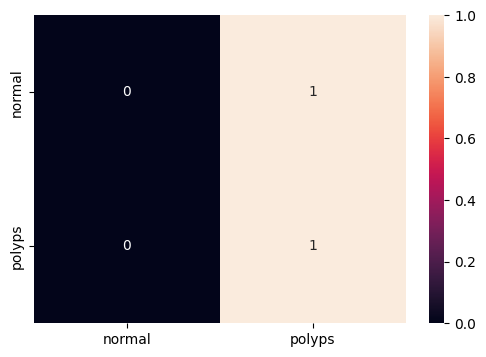

In [38]:
df_cm = pd.DataFrame(cm, index = classes, columns = classes)
plt.figure(figsize = (6, 4))
cm_plot = sns.heatmap(df_cm, annot = True);

### Save CM

In [ ]:
cm_plot.figure.savefig("cm_normal_vs_polyps_vgg16.png")